In [1]:

!pip install genanki pandas
import genanki
import hashlib
import os
import csv
import shutil
from PIL import Image, ImageDraw
import cv2
import numpy as np

Defaulting to user installation because normal site-packages is not writeable


In [2]:


def boxing(image_input):
  """
  Applies bounding boxes to red regions in an image.

  Args:
    image_input: Either a file path (str) or a PIL Image object.

  Returns:
    A PIL Image object with bounding boxes drawn.
  """
  if isinstance(image_input, str):
      # If input is a file path, read the image using cv2
      img = cv2.imread(image_input)
      if img is None:
          raise FileNotFoundError(f"Image not found at {image_input}")
      # Convert OpenCV BGR to RGB for PIL compatibility later
      img_rgb_cv2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img_pil = Image.fromarray(img_rgb_cv2)
  elif isinstance(image_input, Image.Image):
      # If input is a PIL Image, convert it to OpenCV format (BGR)
      img_pil = image_input.convert("RGB") # Ensure RGB format for consistency
      img_rgb_cv2 = np.array(img_pil)
      img = cv2.cvtColor(img_rgb_cv2, cv2.COLOR_RGB2BGR)
  else:
      raise TypeError("Input must be a file path (str) or a PIL Image object")


  # Convert to HSV to isolate red regions (use the BGR image for HSV conversion)
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  # Define red color range and create mask
  lower_red1 = np.array([0, 70, 50])
  upper_red1 = np.array([10, 255, 255])
  lower_red2 = np.array([170, 70, 50])
  upper_red2 = np.array([180, 255, 255])
  mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
  mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
  mask = cv2.bitwise_or(mask1, mask2)

  # Find contours of red regions
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Extract bounding boxes
  boxes = []
  for cnt in contours:
      bbox_x, bbox_y, bbox_w, bbox_h = cv2.boundingRect(cnt)
      # Ignore tiny dots or noise
      if bbox_w > 30 and bbox_h > 5:
          boxes.append((bbox_x, bbox_y, bbox_x + bbox_w, bbox_y + bbox_h))

  # Sort boxes by top-to-bottom, then left-to-right
  boxes = sorted(boxes, key=lambda b: (b[1], b[0]))

  # Draw rectangles on the PIL image object
  draw = ImageDraw.Draw(img_pil)
  for x1, y1, x2, y2 in boxes:
      # Convert coordinates to integers
      x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
      draw.rectangle([(x1, y1), (x2, y2)], outline="darkred", fill="darkred", width=2)

  return img_pil # Return the PIL image object

# Call the function and display the result (example usage - can be removed or commented out)
# Example with file path:
# image_path_example = '/path/to/your/image.jpg'
# if os.path.exists(image_path_example):
#   processed_example = boxing(image_path_example)
#   display(processed_example)
# else:
#   print(f"Example image not found at {image_path_example}")

# Example with PIL Image object (requires a PIL image object to be created first)
# try:
#     pil_image_example = Image.open('/path/to/another/image.png')
#     processed_pil_example = boxing(pil_image_example)
#     display(processed_pil_example)
# except FileNotFoundError:
#     print("Another example image not found.")
# except Exception as e:
#     print(f"Error processing PIL example: {e}")

In [3]:
def find_blue_boxes(image_input):
    """
    Finds blue regions in an image and returns their bounding boxes.

    Args:
        image_input: Either a file path (str) or a PIL Image object.

    Returns:
        A list of tuples (x1, y1, x2, y2) representing the coordinates of blue boxes,
        sorted from top to bottom.
    """
    if isinstance(image_input, str):
        # If input is a file path, read the image using cv2
        img = cv2.imread(image_input)
        if img is None:
            raise FileNotFoundError(f"Image not found at {image_input}")
    elif isinstance(image_input, Image.Image):
        # If input is a PIL Image, convert it to OpenCV format (BGR)
        img_pil = image_input.convert("RGB")  # Ensure RGB format for consistency
        img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    else:
        raise TypeError("Input must be a file path (str) or a PIL Image object")

    # Convert to HSV to isolate blue regions
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define blue color range and create mask
    # Blue typically has a hue value around 120 in HSV
    lower_blue = np.array([100, 50, 50])
    upper_blue = np.array([140, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Find contours of blue regions
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Extract bounding boxes
    boxes = []
    for cnt in contours:
        bbox_x, bbox_y, bbox_w, bbox_h = cv2.boundingRect(cnt)
        # Ignore tiny dots or noise (adjust these thresholds as needed)
        if bbox_w > 30 and bbox_h > 5:
            boxes.append((bbox_x, bbox_y, bbox_x + bbox_w, bbox_y + bbox_h))

    # Sort boxes by top-to-bottom
    boxes = sorted(boxes, key=lambda b: b[1])

    return boxes

def crop_image_to_box(image, box):
    """
    Crops an image to the specified box coordinates.

    Args:
        image: PIL Image object
        box: Tuple of (x1, y1, x2, y2) coordinates

    Returns:
        A PIL Image object containing just the cropped region
    """
    return image.crop(box)

In [4]:


# Define the expected base directory
base_dir = "."

# Check if the base directory exists
if os.path.exists(base_dir):
    print(f"Base directory found: {base_dir}")
    # List subdirectories to further verify
    subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    if subdirs:
        print("Subdirectories found:")
        for subdir in subdirs:
            print(f"- {subdir}")
    else:
        print("No subdirectories found in the base directory.")
else:
    print(f"Base directory not found: {base_dir}")


Base directory found: .
Subdirectories found:
- 완성된 안키 카드들
- 과목들
- .git


In [5]:


# Define the base directory path


# Create an empty list to store the paths of image files
image_files = []

# Traverse the base directory and its subdirectories
for root, dirs, files in os.walk(base_dir):
    for file in files:
        # Check if the file is a regular file and has an image extension
        if os.path.isfile(os.path.join(root, file)) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Construct the full path to the image file
            image_path = os.path.join(root, file)
            # Append the full image path to the list
            image_files.append(image_path)

# Print the total number of image files found and the list of image file paths
print(f"Total number of image files found: {len(image_files)}")
print("Image file paths:")
for image_file in image_files:
    print(image_file)

Total number of image files found: 1
Image file paths:
./과목들/사회학의 이해/E7464B61-0AD1-42B7-911A-B16316645DEC_1_201_a.jpeg


In [6]:

# Create a list to store the specified information for each image
image_data_list = []

# Define the name of the directory to exclude from subjects
anki_cards_dir_name = "완성된 안키 카드들"

# Get the list of immediate subdirectories in the base directory (these are the person names)
try:
    person_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
except FileNotFoundError:
    print(f"Base directory not found: {base_dir}")
    person_dirs = []


for person_name in person_dirs:
    person_root = os.path.join(base_dir, person_name)

    # Get the list of immediate subdirectories within the person's directory (these are the subject names)
    try:
        subject_dirs = [d for d in os.listdir(person_root) if os.path.isdir(os.path.join(person_root, d))]
    except FileNotFoundError:
        print(f"Person directory not found: {person_root}")
        continue

    for subject_name in subject_dirs:
        # Explicitly skip the Anki cards directory
        if subject_name == anki_cards_dir_name:
            continue

        subject_root = os.path.join(person_root, subject_name)

        # Look for image files directly in the subject directory
        try:
            for file in os.listdir(subject_root):
                image_path = os.path.join(subject_root, file)
                # Check if the file is a regular file and has an image extension
                if os.path.isfile(image_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        # Open the original image using PIL
                        original_image = Image.open(image_path)

                        # Get the original filename
                        original_filename = os.path.basename(image_path)

                        # Append the data as a list [person_name, subject_name, original_filename, original_image]
                        image_data_list.append([person_name, subject_name, original_filename, original_image])

                    except Exception as e:
                        print(f"Error processing image {image_path}: {e}")
        except FileNotFoundError:
             print(f"Subject directory not found: {subject_root}")
             continue

# Display the resulting list structure (optional, for verification)
print(image_data_list)

[['과목들', '사회학의 이해', 'E7464B61-0AD1-42B7-911A-B16316645DEC_1_201_a.jpeg', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1478x810 at 0x10D9FD2B0>]]


In [7]:
from PIL import Image

# Define the target width
target_width = 1280

# Iterate through the image_data_list
for item in image_data_list:
    # Get the original image (which is at index 3)
    original_image = item[3]

    # Get the original dimensions
    original_width, original_height = original_image.size

    # Calculate the new height while maintaining the aspect ratio
    # Ensure target_width and original_width are not zero to avoid division by zero
    if original_width > 0:
        aspect_ratio = original_height / original_width
        new_height = int(target_width * aspect_ratio)
    else:
        # Handle cases where original_width is zero (shouldn't happen with valid images, but as a safeguard)
        new_height = original_height # Keep original height if width is zero
        print(f"Warning: Original image width is zero for item: {item[2]}")


    # Resize the image
    try:
        resized_image = original_image.resize((target_width, new_height), Image.Resampling.LANCZOS) # Use LANCZOS for good quality
        # Replace the original image in the list with the resized image
        item[3] = resized_image
    except Exception as e:
        print(f"Error resizing image {item[2]}: {e}")

print(f"Images in image_data_list resized to {target_width} pixels width.")

# Optional: Display the first few resized images to verify
# if len(image_data_list) > 0:
#     print("First few resized images:")
#     for i in range(min(3, len(image_data_list))):
#         display(image_data_list[i][3])

Images in image_data_list resized to 1280 pixels width.


Processing full image: E7464B61-0AD1-42B7-911A-B16316645DEC_1_201_a.jpeg (from 과목들/사회학의 이해)
  Original Image:


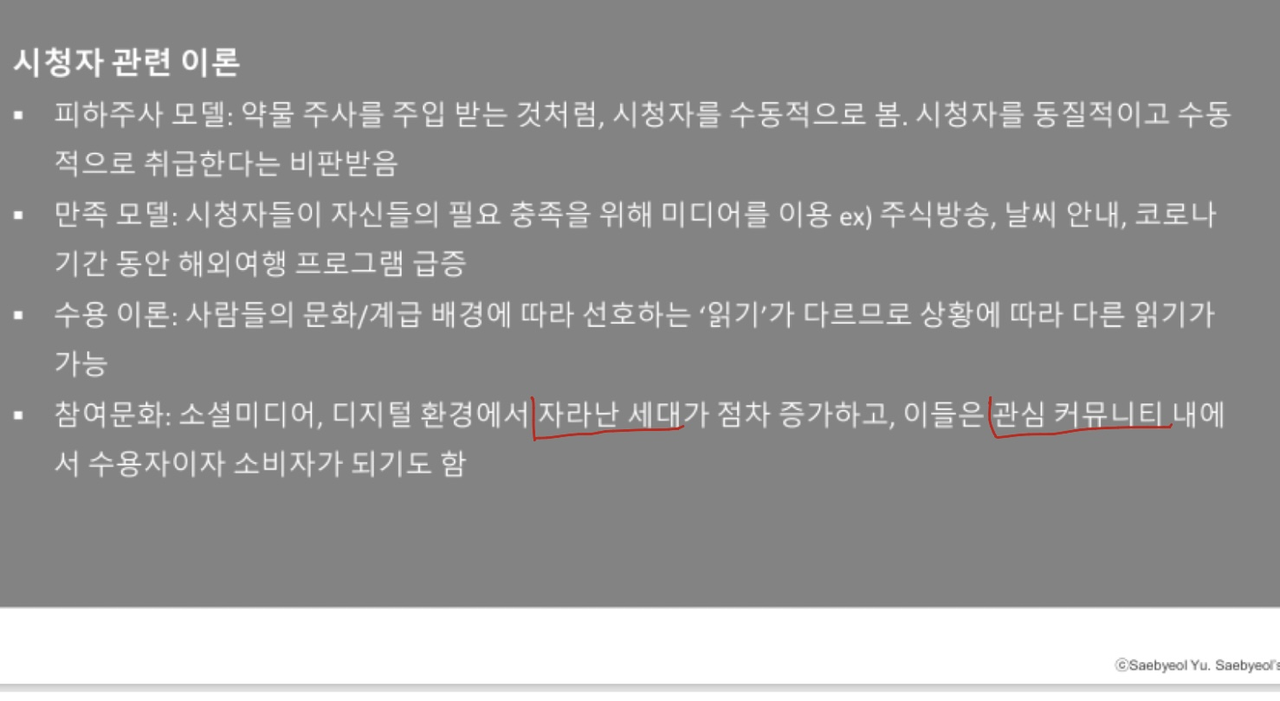

  Processed Image:


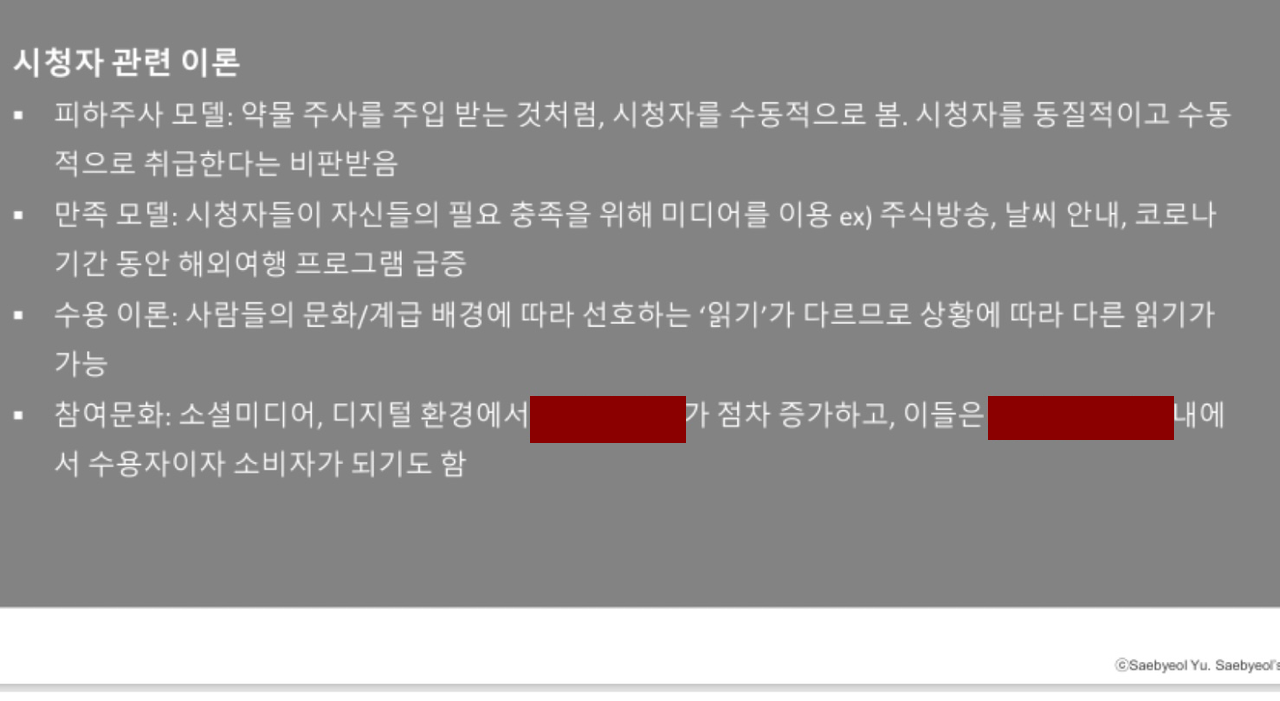

--------------------
Image processing completed.


In [8]:
from IPython.display import display

# Iterate through the image_data_list
for item in image_data_list:
    # Get the original image (which is at index 3)
    original_image = item[3]

    try:
        # First, check for blue boxes
        blue_boxes = find_blue_boxes(original_image)
        
        if blue_boxes:
            # If blue boxes exist, process each blue box separately
            print(f"Found {len(blue_boxes)} blue boxes in image: {item[2]} (from {item[0]}/{item[1]})")
            
            # Create a list to store processed regions for this image
            processed_regions = []
            
            for i, blue_box in enumerate(blue_boxes):
                # Crop the image to the blue box region
                cropped_image = crop_image_to_box(original_image, blue_box)
                
                # Apply the boxing function to find red regions in the cropped area
                processed_cropped = boxing(cropped_image)
                
                # Store the processed region along with its index
                processed_regions.append((i, cropped_image, processed_cropped))
                
                # Display the cropped regions
                print(f"  Blue box region {i+1}:")
                print("    Original cropped region:")
                display(cropped_image)
                print("    Processed cropped region:")
                display(processed_cropped)
                
            # Add the processed regions to the item
            item.append(processed_regions)
            
        else:
            # If no blue boxes, process the entire image as before
            processed_image = boxing(original_image)
            
            # Display the original and processed images
            print(f"Processing full image: {item[2]} (from {item[0]}/{item[1]})")
            print("  Original Image:")
            display(original_image)
            print("  Processed Image:")
            display(processed_image)
            
            # Add the processed image to the item (with None as index to indicate full image)
            item.append([(None, original_image, processed_image)])
        
        print("-" * 20)  # Separator for clarity

    except Exception as e:
        print(f"Error processing image {item[2]} (from {item[0]}/{item[1]}): {e}")

print("Image processing completed.")

In [9]:
# Define the directory where the CSV and image files will be saved
output_dir = "./processed_images_output"
os.makedirs(output_dir, exist_ok=True)

# Define the path for the output CSV file
csv_output_path = os.path.join(output_dir, "image_pairs.csv")

# Open the CSV file for writing
with open(csv_output_path, 'w', newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile)

    # Iterate through the image_data_list
    # Each item now contains [person_name, subject_name, original_filename, original_image, processed_regions]
    for item in image_data_list:
        original_filename = item[2]
        processed_regions = item[4]  # List of (index, original_crop, processed_crop)

        # Process each region (either cropped from blue box or full image)
        for idx, orig_crop, proc_crop in processed_regions:
            # Generate filenames for this region
            name, ext = os.path.splitext(original_filename)
            if idx is not None:
                # For blue box regions, add region number
                region_suffix = f"_region{idx+1}"
            else:
                # For full images (no blue boxes), don't add region number
                region_suffix = ""

            processed_img_save_name = f"{name}{region_suffix}-1_processed{ext}"
            original_img_save_name = f"{name}{region_suffix}-1_original{ext}"

            # Define full paths for saving the images
            processed_img_save_path = os.path.join(output_dir, processed_img_save_name)
            original_img_save_path = os.path.join(output_dir, original_img_save_name)

            # Save the processed and original images
            proc_crop.save(processed_img_save_path)
            orig_crop.save(original_img_save_path)

            # Write a row to the CSV with the image filenames
            csv_writer.writerow([processed_img_save_name, original_img_save_name])

print(f"CSV file and images saved to: {output_dir}")

CSV file and images saved to: ./processed_images_output


## Group data by person and subject

### Subtask:
Process the `image_data_list` to group the image data by person and then by subject.


**Reasoning**:
Initialize an empty dictionary and iterate through the image_data_list to group the data by person and then by subject as described in the instructions.



In [10]:
grouped_data = {}

for item in image_data_list:
    person_name = item[0]
    subject_name = item[1]

    if person_name not in grouped_data:
        grouped_data[person_name] = {}

    if subject_name not in grouped_data[person_name]:
        grouped_data[person_name][subject_name] = []

    grouped_data[person_name][subject_name].append(item)

# Optional: Display the grouped_data structure to verify
# print(grouped_data)

## Iterate through grouped data

### Subtask:
Loop through the grouped data, processing each subject for each person.


**Reasoning**:
Iterate through the grouped data by person and subject to prepare for Anki deck creation.



In [11]:
for person_name, subjects_data in grouped_data.items():
    print(f"Processing person: {person_name}")
    for subject_name, image_items in subjects_data.items():
        print(f"  Processing subject: {subject_name}")
        # The image_items list contains all the data for this person and subject
        # print(f"    Found {len(image_items)} images for this subject.") # Optional: verify count
        # The next steps will involve creating an Anki deck using genanki for these image_items

Processing person: 과목들
  Processing subject: 사회학의 이해


## Create anki deck and model

### Subtask:
For each subject, create a `genanki.Deck` and `genanki.Model` with appropriate fields and templates.


**Reasoning**:
Define the Anki model and deck structure for each subject.



In [12]:

# Base model ID
base_model_id = 1234567890

# Store decks to process later
decks_to_create = []

# Iterate through the grouped data
for person_name, subjects_data in grouped_data.items():
    print(f"Processing person: {person_name}")
    for subject_name, image_items in subjects_data.items():
        print(f"  Processing subject: {subject_name}")

        # Generate a unique model ID based on the subject name
        # Using hashlib to ensure uniqueness per subject
        subject_hash = int(hashlib.sha256(subject_name.encode('utf-8')).hexdigest(), 16) % (10**9) # Limit hash to 9 digits
        model_id = base_model_id + subject_hash

        # Define the Anki Model
        my_model = genanki.Model(
            model_id,
            'Simple Image Card',
            fields=[
                {'name': 'Processed Image'},
                {'name': 'Original Image'},
                {'name': 'Original Filename'}, # Field for the original filename
            ],
            templates=[
                {
                    'name': 'Card 1',
                    'qfmt': '{{Processed Image}}',  # Front of the card shows the processed image
                    'afmt': '{{FrontSide}}<hr id="answer">{{Original Image}}<br>Original Filename: {{Original Filename}}', # Back shows original image and filename
                },
            ])

        # Create the Anki Deck for the subject
        my_deck = genanki.Deck(
            abs(hash(subject_name)), # Use a hash of the subject name for deck ID
            '자동으로 만든 덱::자동으로 만든 '+subject_name)

        # Store the deck and the associated image items
        decks_to_create.append((my_deck, my_model, image_items, person_name, subject_name))

print("Anki models and decks defined. Ready to create notes and packages.")

Processing person: 과목들
  Processing subject: 사회학의 이해
Anki models and decks defined. Ready to create notes and packages.


In [13]:
# Iterate through the stored decks and image items
for my_deck, my_model, image_items, person_name, subject_name in decks_to_create:
    print(f"Creating notes for deck: {subject_name} ({person_name})")

    # Add notes to the deck
    for item in image_data_list:
        original_filename = item[2]
        processed_regions = item[4]  # List of (index, original_crop, processed_crop)
        
        # If there are blue boxes, we'll combine all regions into one note
        if processed_regions and processed_regions[0][0] is not None:
            # Generate HTML for all processed regions
            processed_html = []
            original_html = []
            
            for idx, orig_crop, proc_crop in processed_regions:
                name, ext = os.path.splitext(original_filename)
                region_suffix = f"_region{idx+1}"
                
                processed_img_filename = f"{name}{region_suffix}-1_processed{ext}"
                original_img_filename = f"{name}{region_suffix}-1_original{ext}"
                
                processed_html.append(f'<img src="{processed_img_filename}">')
                original_html.append(f'<img src="{original_img_filename}">')
            
            # Create one note with all regions
            my_note = genanki.Note(
                model=my_model,
                fields=[
                    '<br>'.join(processed_html),  # All processed regions stacked vertically
                    '<br>'.join(original_html),   # All original regions stacked vertically
                    original_filename             # Original filename without region suffix
                ])
            
            my_deck.add_note(my_note)
            
        else:
            # For images without blue boxes, create a single note as before
            processed_img_filename = f"{original_filename.rsplit('.', 1)[0]}-1_processed.{original_filename.rsplit('.', 1)[1]}"
            original_img_filename = f"{original_filename.rsplit('.', 1)[0]}-1_original.{original_filename.rsplit('.', 1)[1]}"
            
            my_note = genanki.Note(
                model=my_model,
                fields=[
                    f'<img src="{processed_img_filename}">',
                    f'<img src="{original_img_filename}">',
                    original_filename
                ])
            
            my_deck.add_note(my_note)

    print(f"Finished creating notes for deck: {subject_name} ({person_name})")

print("All notes created and added to their respective decks.")

Creating notes for deck: 사회학의 이해 (과목들)
Finished creating notes for deck: 사회학의 이해 (과목들)
All notes created and added to their respective decks.


**Reasoning**:
Package each deck into an .apkg file, including the associated media files (processed and original images).



In [14]:
# Define the base directory where the decks will be saved
anki_output_dir = os.path.join(base_dir, "완성된 안키 카드들")

# Create the output directory if it doesn't exist
os.makedirs(anki_output_dir, exist_ok=True)

# Iterate through the stored decks and image items
for my_deck, my_model, image_items, person_name, subject_name in decks_to_create:
    # Define the base output filename for the Anki package (.apkg)
    base_apkg_filename = f"완성된 {subject_name}.apkg"
    apkg_output_path = os.path.join(anki_output_dir, base_apkg_filename)

    # Check if the file already exists and modify the filename if necessary
    counter = 1
    while os.path.exists(apkg_output_path):
        name, ext = os.path.splitext(base_apkg_filename)
        apkg_filename = f"{name}-{counter}{ext}"
        apkg_output_path = os.path.join(anki_output_dir, apkg_filename)
        counter += 1

    print(f"Packaging deck: {subject_name} for {person_name} to {apkg_output_path}")

    # Gather media files for this deck
    media_files = []
    for item in image_items:
        original_filename = item[2]
        processed_regions = item[4]  # List of (index, original_crop, processed_crop)

        if processed_regions and processed_regions[0][0] is not None:
            # For images with blue boxes, include all regions
            for idx, orig_crop, proc_crop in processed_regions:
                name, ext = os.path.splitext(original_filename)
                region_suffix = f"_region{idx+1}"
                
                # Use the same filenames as saved in processed_images_output
                processed_img_filename = f"{name}{region_suffix}-1_processed{ext}"
                original_img_filename = f"{name}{region_suffix}-1_original{ext}"

                # Get the full paths of the saved images
                processed_img_path = os.path.join("./processed_images_output", processed_img_filename)
                original_img_path = os.path.join("./processed_images_output", original_img_filename)

                # Add the full paths to the media_files list
                media_files.append(processed_img_path)
                media_files.append(original_img_path)
        else:
            # For images without blue boxes
            name, ext = os.path.splitext(original_filename)
            processed_img_filename = f"{name}-1_processed{ext}"
            original_img_filename = f"{name}-1_original{ext}"

            # Get the full paths of the saved images
            processed_img_path = os.path.join("./processed_images_output", processed_img_filename)
            original_img_path = os.path.join("./processed_images_output", original_img_filename)

            # Add the full paths to the media_files list
            media_files.append(processed_img_path)
            media_files.append(original_img_path)

    # Create the Anki package with the media files
    try:
        genanki.Package(my_deck, media_files=media_files).write_to_file(apkg_output_path)
        print(f"Successfully created Anki package: {apkg_output_path}")
    except Exception as e:
        print(f"Error creating Anki package: {e}")

print("All Anki packages created (with naming adjustments for existing files).")

Packaging deck: 사회학의 이해 for 과목들 to ./완성된 안키 카드들/완성된 사회학의 이해.apkg
Successfully created Anki package: ./완성된 안키 카드들/완성된 사회학의 이해.apkg
All Anki packages created (with naming adjustments for existing files).


In [ ]:

# Define the base directory path
base_dir = "."

# Define the name of the directory to exclude from subject processing
anki_cards_dir_name = "완성된 안키 카드들"

# Traverse the base directory and its subdirectories
for root, dirs, files in os.walk(base_dir, topdown=True):
    # Exclude the anki_cards_dir_name from traversal
    if anki_cards_dir_name in dirs:
        dirs.remove(anki_cards_dir_name)

    for file in files:
        # Construct the full path to the file
        file_path = os.path.join(root, file)

        # Check if the file is a regular file and has an image extension
        if os.path.isfile(file_path) and file.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                # Delete the image file
                os.remove(file_path)
                print(f"Deleted: {file_path}")
            except OSError as e:
                print(f"Error deleting file {file_path}: {e}")

print("Image deletion process completed.")
# Clean up processed_images_output directory
processed_output_dir = "./processed_images_output"
if os.path.exists(processed_output_dir):
    try:
        # Remove all files in the directory
        for filename in os.listdir(processed_output_dir):
            file_path = os.path.join(processed_output_dir, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Deleted processed image: {file_path}")
        
        # Remove the directory itself
        os.rmdir(processed_output_dir)
        print(f"Deleted directory: {processed_output_dir}")
    except Exception as e:
        print(f"Error cleaning up processed_images_output directory: {e}")

print("Processed images cleanup completed.")

Deleted: ./processed_images_output/E7464B61-0AD1-42B7-911A-B16316645DEC_1_201_a-1_processed.jpeg
Deleted: ./processed_images_output/E7464B61-0AD1-42B7-911A-B16316645DEC_1_201_a-1_original.jpeg
Deleted: ./과목들/사회학의 이해/E7464B61-0AD1-42B7-911A-B16316645DEC_1_201_a.jpeg
Image deletion process completed.
Deleted processed image: ./processed_images_output/image_pairs.csv
Deleted directory: ./processed_images_output
Processed images cleanup completed.
